In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/1e5ba644-efeb-4bd3-b878-a0606cf8a992___RS_Late.B 6272_flipLR.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/3dcee9ed-43bb-45a9-8cff-641b3dd62179___RS_Late.B 5324.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/532b2c20-d17b-4b3e-a69e-54a6e5343014___GHLB2 Leaf 9004.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/418ae33c-5f61-4531-82df-8608d82a7a90___RS_Late.B 5574.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/7f4621fe-72ce-4f4c-a20e-320250ec8a9d___R

KeyboardInterrupt: 

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split,Dataset
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
%matplotlib inline
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from torchvision.datasets import ImageFolder  # for working with classes and images


In [3]:
# Paths
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [4]:
random_seed = 7
torch.manual_seed(random_seed)

In [5]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 


In [7]:
batch_size = 32


In [8]:
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

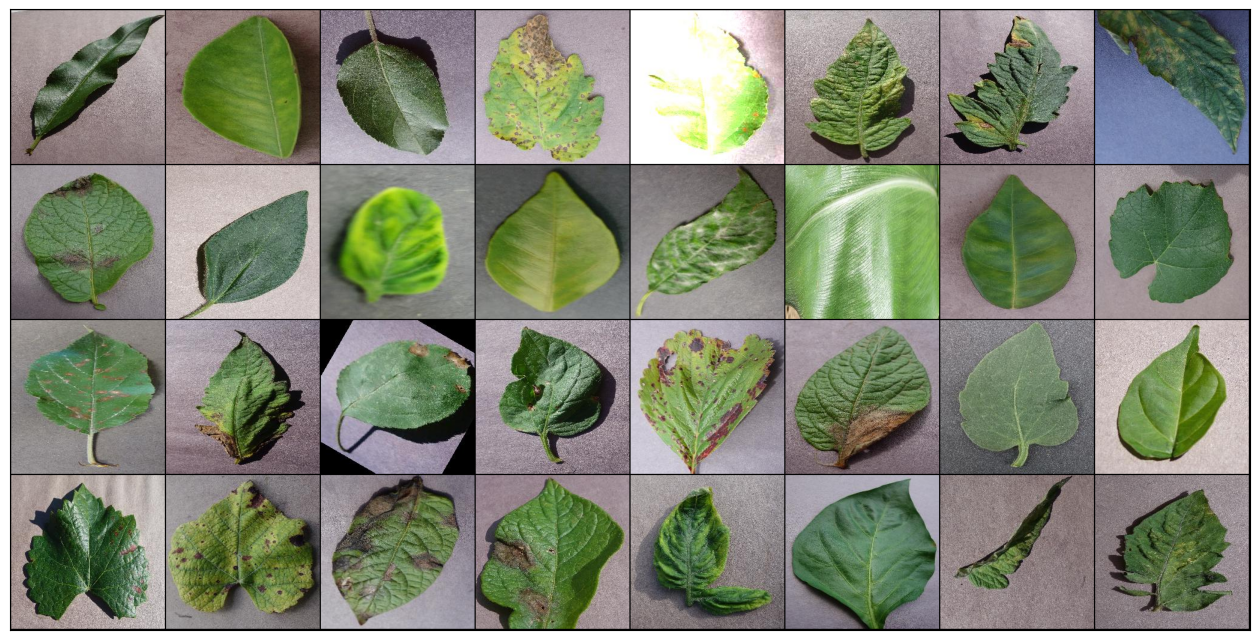

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

    @torch.no_grad()
    def evaluate(self, valid_dl):  # Added 'self' here
        self.eval()  # Set model to evaluation mode
        total_loss, total_correct, total_samples = 0, 0, 0

        for xb, yb in valid_dl:
            # Ensure both xb and yb are on the same device (device is defined globally)
            xb, yb = xb.to(device), yb.to(device)

            # Move the model to the correct device
            self.to(device)  # This line is added

            preds = self(xb)

            loss = F.cross_entropy(preds, yb)
            total_loss += loss.item()

            total_correct += (preds.argmax(1) == yb).sum().item()
            total_samples += yb.size(0)

        return total_loss / total_samples, total_correct / total_samples



In [12]:

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [14]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
import torch
from tqdm.notebook import tqdm


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = model.evaluate(val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        val_loss, val_acc = model.evaluate(val_loader)  # Unpack tuple
        result = {'val_loss': val_loss, 'val_acc': val_acc}  # Now it's a dictionary
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [16]:
device = get_default_device()
device


device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [19]:
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [20]:
history = [model.evaluate(valid_dl)]
history

[(0.11385690936623254, 0.028283633052583655)]

In [21]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [22]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00104, train_loss: 0.4835, val_loss: 0.0098, val_acc: 0.9009


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00280, train_loss: 0.2898, val_loss: 0.0133, val_acc: 0.8714


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00520, train_loss: 0.2688, val_loss: 0.0315, val_acc: 0.7495


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00760, train_loss: 0.2324, val_loss: 0.0253, val_acc: 0.7732


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00936, train_loss: 0.2253, val_loss: 0.0154, val_acc: 0.8665


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.01000, train_loss: 0.2156, val_loss: 0.0261, val_acc: 0.7503


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00987, train_loss: 0.1919, val_loss: 0.0192, val_acc: 0.8228


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00950, train_loss: 0.1747, val_loss: 0.0085, val_acc: 0.9112


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00891, train_loss: 0.1614, val_loss: 0.0163, val_acc: 0.8385


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00812, train_loss: 0.1495, val_loss: 0.0064, val_acc: 0.9340


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00717, train_loss: 0.1333, val_loss: 0.0052, val_acc: 0.9457


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00611, train_loss: 0.1133, val_loss: 0.0045, val_acc: 0.9546


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00500, train_loss: 0.0966, val_loss: 0.0031, val_acc: 0.9664


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00389, train_loss: 0.0785, val_loss: 0.0039, val_acc: 0.9570


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00283, train_loss: 0.0613, val_loss: 0.0029, val_acc: 0.9696


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [15],last_lr: 0.00188, train_loss: 0.0429, val_loss: 0.0014, val_acc: 0.9849


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [16],last_lr: 0.00109, train_loss: 0.0277, val_loss: 0.0012, val_acc: 0.9870


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [17],last_lr: 0.00050, train_loss: 0.0164, val_loss: 0.0008, val_acc: 0.9924


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [18],last_lr: 0.00013, train_loss: 0.0096, val_loss: 0.0007, val_acc: 0.9929


  0%|          | 0/2197 [00:00<?, ?it/s]

Epoch [19],last_lr: 0.00000, train_loss: 0.0069, val_loss: 0.0006, val_acc: 0.9930
CPU times: user 1h 31min 59s, sys: 1h 23min 44s, total: 2h 55min 43s
Wall time: 2h 41min 41s


In [23]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)

In [24]:
print('hello')

hello
